In this notebook, we will train an RCM emulator from scratch using PyTorch and the CORDEX Benchmark dataset (for more information on the data, see the notebooks in `../data`).

The workflow is as follows:

- Train the RCM emulator under a either of the two training configurations available.
- Evaluate it on a subset of the same RCM simulations used for training.
- Compute predictions for the different evalaution experiments included in the benchmark.

We have kept the set of dependencies minimal. For further details, see the README or `../requirements`

In [1]:
import os
import xarray as xr
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature

import sys
sys.path.append('../evaluation')
import indices, diagnostics

First, we define two functions to facilitate plotting of the generated data, including the Power Spectral Density (PSD), which will be used to evaluate the RCM emulator.

In [2]:
def plot_data_map(data, var_name, domain, vmin, vmax,
                  fig_title='', figsize=(8,8), cmap='viridis'):
    
    central_longitude = 180 if domain == 'NZ' else 0 if domain == 'ALPS' else None
    
    plt.figure(figsize=figsize)
    ax = plt.axes(projection=ccrs.PlateCarree(central_longitude=central_longitude))

    if domain == 'NZ':
        data[var_name].plot(ax=ax, transform=ccrs.PlateCarree(),
                            vmin=vmin, vmax=vmax,
                            cmap=cmap)
    elif domain == 'ALPS':
        cs = ax.pcolormesh(data[var_name]['lon'], data[var_name]['lat'],
                           data[var_name],
                           transform=ccrs.PlateCarree(),
                           vmin=vmin, vmax=vmax,
                           cmap=cmap)
    
    ax.coastlines(resolution='10m')
    ax.add_feature(cfeature.BORDERS, linestyle=':')
    
    plt.title(fig_title)
    plt.show()

def plot_psd(psd_target, psd_pred):
    plt.loglog(psd_target.wavenumber, psd_target, label="Target")
    plt.loglog(psd_pred.wavenumber, psd_pred, label="Prediction")
    plt.xlabel("Wavenumber")
    plt.title("Power Spectral Density")
    plt.legend()
    plt.show()

We define the PATHs for the data (which must match those used when downloading the benchmark dataset) and for saving the models.

In [3]:
DATA_PATH = '../data/Bench-data'

MODELS_PATH = './models'
os.makedirs(MODELS_PATH, exist_ok=True)

For this example, we select the NZ domain. (The code, as written, is also valid for the ALPS domain.)

In [4]:
domain = 'ALPS'
training_experiment = 'ESD_pseudo_reality'

In [5]:
# Set the period
if training_experiment == 'ESD_pseudo_reality':
    period_training = '1961-1980'
elif training_experiment == 'Emulator_hist_future':
    period_training = '1961-1980_2080-2099'
else:
    raise ValueError('Provide a valid date')

# Set the GCM
if domain == 'ALPS':
    gcm_name = 'CNRM-CM5'
elif domain == 'NZ':
    gcm_name = 'ACCESS-CM2'

We load the predictor. For more details on the properties of this dataset (and the predictand), see `./data/experiments.ipynb`.

In [6]:
predictor_filename = f'{DATA_PATH}/{domain}/{domain}_domain/train/{training_experiment}/predictors/{gcm_name}_{period_training}.nc'
predictor = xr.open_dataset(predictor_filename)

As predictands, the benchmark provides both daily maximum temperature (`tasmax`) and daily accumulated precipitation (`pr`). For this tutorial, we focus on maximum temperature.

In [7]:
var_target = 'tasmax'

predictand_filename = f'{DATA_PATH}/{domain}/{domain}_domain/train/{training_experiment}/target/pr_tasmax_{gcm_name}_{period_training}.nc'
predictand = xr.open_dataset(predictand_filename)
predictand = predictand[[var_target]]

Unfortunately, the benchmark does not yet provide ground-truth data (target RCM simulations) for the evaluation experiments. Therefore, to get an initial sense of the trained DL emulator’ performance, we generate a test set from the data used for training. Evaluating on this test set provides an indication of how well the emulator is performing.

In [8]:
if training_experiment == 'ESD_pseudo_reality':
    years_train = list(range(1961, 1975))
    years_test = list(range(1975, 1980+1))
elif training_experiment == 'Emulator_hist_fut':
    years_train = list(range(1961, 1980+1)) + list(range(2080, 2090))
    years_test = list(range(2090, 2099+1))

x_train = predictor.sel(time=np.isin(predictor['time'].dt.year, years_train))
y_train = predictand.sel(time=np.isin(predictand['time'].dt.year, years_train))

x_test = predictor.sel(time=np.isin(predictor['time'].dt.year, years_test))
y_test = predictand.sel(time=np.isin(predictand['time'].dt.year, years_test))

As is typical in the DL community, we standardize the training predictors to have a mean of zero and a standard deviation of one. Importantly, the test predictors are standardized using the mean and standard deviation from the training set. This approach ensures that the input data scale remains consistent.

In [9]:
mean_train = x_train.mean('time')
std_train = x_train.std('time')

x_train_stand = (x_train - mean_train) / std_train
x_test_stand = (x_test - mean_train) / std_train

In this tutorial, we train a DL model with a final fully connected layer, so the model output is a flattened vector (which we will later reshape to its original 2D dimensions). Therefore, the target data must also be flattened for training.

In [10]:
if domain == 'ALPS':
    spatial_dims = ('x', 'y')
elif domain == 'NZ':
    spatial_dims = ('lat', 'lon')

y_train_stack = y_train.stack(gridpoint=spatial_dims)
y_test_stack = y_test.stack(gridpoint=spatial_dims)

Finally, we extract the raw data from the `xarray.Dataset` as a NumPy array and convert it to a PyTorch tensor.

In [11]:
x_train_stand_array = torch.from_numpy(x_train_stand.to_array().transpose("time", "variable", "lat", "lon").values)
y_train_stack_array = torch.from_numpy(y_train_stack.to_array()[0, :].values)

x_test_stand_array = torch.from_numpy(x_test_stand.to_array().transpose("time", "variable", "lat", "lon").values)

We define two separate Dataset objects: one for training (outputting both inputs and targets) and one for making predictions (outputting only the inputs).

In [12]:
class EmulationTrainingDataset(Dataset):
    def __init__(self, x_data, y_data):
        if not isinstance(x_data, torch.Tensor):
            x_data = torch.tensor(x_data)
        if not isinstance(y_data, torch.Tensor):
            y_data = torch.tensor(y_data)
        self.x_data, self.y_data = x_data, y_data

    def __len__(self):
        return len(self.x_data)

    def __getitem__(self, idx):
        x_sample, y_sample = self.x_data[idx, :], self.y_data[idx, :]
        return x_sample, y_sample

class EmulationTestDataset(Dataset):
    def __init__(self, x_data):
        if not isinstance(x_data, torch.Tensor):
            x_data = torch.tensor(x_data)
        self.x_data = x_data

    def __len__(self):
        return len(self.x_data)

    def __getitem__(self, idx):
        return self.x_data[idx, :]

We set training Dataset and DataLoader.

In [13]:
dataset_training = EmulationTrainingDataset(x_data=x_train_stand_array, y_data=y_train_stack_array)
dataloader_train = DataLoader(dataset=dataset_training,
                              batch_size=32, shuffle=True)

Now we define the DL architecture to use as our RCM emulator. In this example, we use DeepESD [1], a model previously applied for both observational statistical downscaling and RCM emulation [2]. The architecture consists of three convolutional layers followed by a final dense layer. Despite its simplicity, DeepESD has demonstrated strong performance and has been successfully applied across various domains.

In [14]:
class DeepESD(torch.nn.Module):

    def __init__(self, x_shape: tuple, y_shape: tuple,
                 filters_last_conv: int):

        super(DeepESD, self).__init__()

        self.x_shape = x_shape
        self.y_shape = y_shape
        self.filters_last_conv = filters_last_conv

        self.conv_1 = torch.nn.Conv2d(in_channels=self.x_shape[1],
                                      out_channels=50,
                                      kernel_size=3,
                                      padding=1)

        self.conv_2 = torch.nn.Conv2d(in_channels=50,
                                      out_channels=25,
                                      kernel_size=3,
                                      padding=1)

        self.conv_3 = torch.nn.Conv2d(in_channels=25,
                                      out_channels=self.filters_last_conv,
                                      kernel_size=3,
                                      padding=1)

        self.out = torch.nn.Linear(in_features=\
                                       self.x_shape[2] * self.x_shape[3] * self.filters_last_conv,
                                       out_features=self.y_shape[1])

    def forward(self, x: torch.Tensor) -> torch.Tensor:

        x = self.conv_1(x)
        x = torch.relu(x)

        x = self.conv_2(x)
        x = torch.relu(x)

        x = self.conv_3(x)
        x = torch.relu(x)

        x = torch.flatten(x, start_dim=1)

        out = self.out(x)

        return out

In [15]:
model = DeepESD(x_shape=x_train_stand_array.shape,
                y_shape=y_train_stack_array.shape,
                filters_last_conv=1)
print(model)

DeepESD(
  (conv_1): Conv2d(15, 50, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv_2): Conv2d(50, 25, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv_3): Conv2d(25, 1, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (out): Linear(in_features=256, out_features=16384, bias=True)
)


We use Mean Squared Error (MSE) as the loss function, which is commonly employed for temperature-related tasks. If working with precipitation instead, we recommend exploring alternative loss functions, since MSE is not well-suited for learning distributions with strong skewness, such as precipitation. For further details, see [3].

In [16]:
loss_function = nn.MSELoss()

We set the hyperparameters that control how the model weights are learned and select the available device for training.

In [17]:
learning_rate = 0.0001
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

num_epochs = 500

In [18]:
device = ('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)

Below, we define the `for` loop to train the model. While there are simpler ways to train DL models within the PyTorch ecosystem, this implementation is useful to gain a clear understanding of the entire training process.

In [20]:
# Initialize a list to store the loss per epoch
loss_train = []

# Iterate over the epochs
for epoch in range(num_epochs):
    # Define a variable to accumulate the cost function value per epoch
    epoch_loss = 0.0 
    
    # Iterate over the batches
    for idx, (batch_x_data, batch_y_data) in enumerate(dataloader_train):
        batch_size = batch_x_data.shape[0]

        # Move data to the device
        batch_x_data = batch_x_data.to(device)
        batch_y_data = batch_y_data.to(device)
        
        # Zero the gradients since by default they accumulate
        optimizer.zero_grad()

        # Compute the forward pass
        outputs = model(batch_x_data)  # PyTorch calls model.forward() internally

        # Compute the cost function
        loss_batch = loss_function(outputs, batch_y_data)
        epoch_loss += batch_size * loss_batch.item()

        # Compute the gradients (backward pass)
        loss_batch.backward()

        # Update the model weights
        optimizer.step()

    # Calculate the loss for the epoch
    epoch_loss = epoch_loss / len(dataset_training)
    loss_train.append(epoch_loss)
    
    # Print every 10 epochs
    if (epoch + 1) % 10 == 0 or epoch == 0:
        print(f'Epoch {epoch+1}/{num_epochs} - Loss: {epoch_loss:.6f}')

# At the end of training, save the model weights
model_name = 'model.pt'
torch.save(model.state_dict(), f'{MODELS_PATH}/{model_name}')

Once the model is trained, we can compute predictions on the test set defined at the beginning of the notebook. To do this, we create a DataLoader for the test data and pass it through the trained model, obtaining predictions for the entire test set.

In [21]:
dataset_test = EmulationTestDataset(x_data=x_test_stand_array)
test_dataloader = DataLoader(dataset=dataset_test,
                             batch_size=32, shuffle=False)

# Compute predictions
model.eval()

predictions = []
with torch.no_grad():
    for batch_x in test_dataloader:
        batch_x = batch_x.to(next(model.parameters()).device)
        outputs = model(batch_x)
        predictions.append(outputs.cpu().numpy())

# Concatenate all batches into one array
predictions = np.concatenate(predictions, axis=0)

The DeepESD model outputs a flattened version of the RCM simulations, so we need to reshape it back to 2D. This is done in the following cell.

In [22]:
y_pred_stack = y_test_stack.copy(deep=True)
y_pred_stack[var_target].values = predictions
y_pred = y_pred_stack.unstack()

Once the predictions for the test set have been computed, we can evaluate them using several metrics introduced in the class slides. Specifically, we compute the following metrics:

- Root Mean Squared Error (RMSE)
- Bias of the mean
- Bias of the 98th percentile
- Ratio of standard deviations
- Power Spectral Density (PSD)

The implementations of these metrics can be found in `../evaluation/metrics.py`.

Mean RMSE: 1.9187920093536377


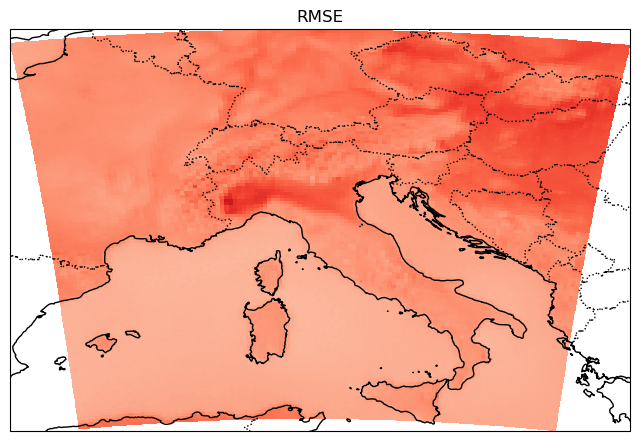

In [23]:
rmse = diagnostics.rmse(target=y_test, pred=y_pred,
                        var=var_target, dim='time')
print(f'Mean RMSE: {rmse[var_target].mean().values.item()}')

plot_data_map(data=rmse, var_name=var_target, domain=domain, vmin=0, vmax=5,
              fig_title='RMSE', cmap='Reds')

Mean Bias Mean: 0.027001766487956047


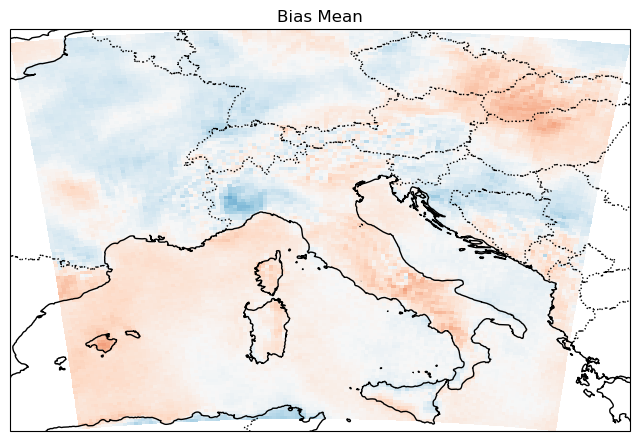

In [24]:
bias_mean = diagnostics.bias_index(target=y_test, pred=y_pred,
                                   index_fn=indices._mean,
                                   var=var_target)
print(f'Mean Bias Mean: {bias_mean[var_target].mean().values.item()}')

plot_data_map(data=bias_mean, var_name=var_target, domain=domain, vmin=-2, vmax=2,
              fig_title='Bias Mean', cmap='RdBu_r')

Mean Bias 98th percentile: 0.044591255597770774


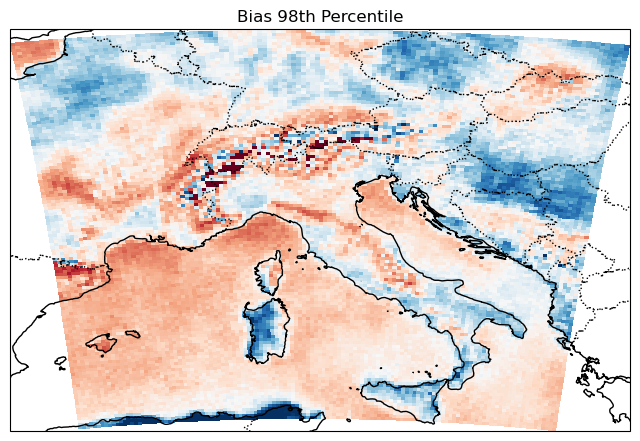

In [25]:
bias_p98 = diagnostics.bias_index(target=y_test, pred=y_pred,
                                  index_fn=indices._quantile,
                                  q=0.98,
                                  var=var_target)
print(f'Mean Bias 98th percentile: {bias_p98[var_target].mean().values.item()}')

plot_data_map(data=bias_p98, var_name=var_target, domain=domain, vmin=-2, vmax=2,
              fig_title='Bias 98th Percentile', cmap='RdBu_r')

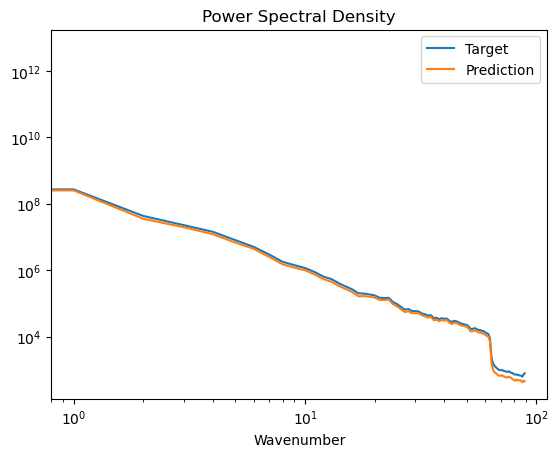

In [26]:
psd_target, psd_pred = diagnostics.psd(target=y_test, pred=y_pred,
                                       var=var_target)
plot_psd(psd_target=psd_target, psd_pred=psd_pred)

For visualization purposes, we also plot the RCM simulation alongside the emulator’s prediction for a specific day.

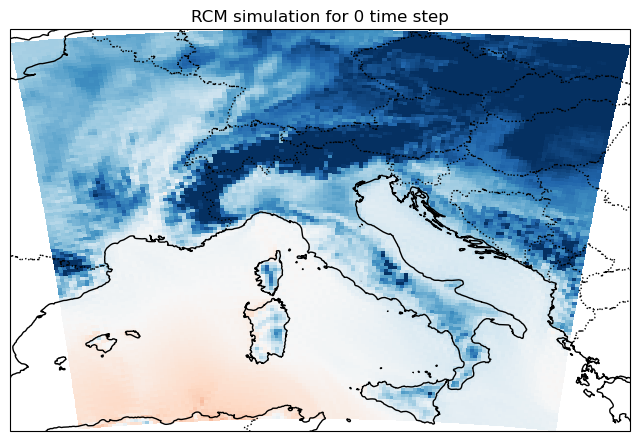

In [27]:
time_idx = 0

plot_data_map(data=y_test.isel(time=time_idx), var_name=var_target, domain=domain,
              vmin=275, vmax=300,
              fig_title=f'RCM simulation for {time_idx} time step', figsize=(8,8), cmap='RdBu_r')

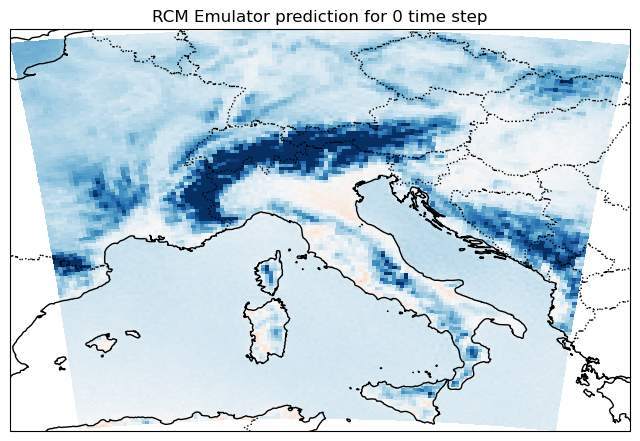

In [28]:
plot_data_map(data=y_pred.isel(time=0), var_name=var_target, domain=domain,
              vmin=275, vmax=300,
              fig_title=f'RCM Emulator prediction for {time_idx} time step', figsize=(8,8), cmap='RdBu_r')

Once the RCM emulator is trained, we can compute predictions for the different evaluation experiments. For details on how the data is loaded, please refer to `../data/experiments.ipynb`. We set the evaluation experiment in the following cell.

In [29]:
evaluation_experiment = 'PP_cross_validation'

In [30]:
# Define experiment settings
evaluation_experiment_settings = {
    "ESD_pseudo_reality": {
        "PP_cross_validation": ("historical", "perfect", True),
        "Imperfect_cross_validation": ("historical", "imperfect", True),
        "Extrapolation_perfect": ("mid_end_century", "perfect", True),
        "Extrapolation_imperfect": ("mid_end_century", "imperfect", True),
    },
    "Emulator_hist_future": {
        "PP_cross_validation": ("historical", "perfect", True),
        "Imperfect_cross_validation": ("historical", "imperfect", True),
        "Extrapolation_perfect": ("mid_end_century", "perfect", True),
        "Extrapolation_perfect_hard": ("mid_end_century", "perfect", False),
        "Extrapolation_imperfect_hard": ("mid_end_century", "imperfect", False),
    },
}

# Get settings for the chosen experiments
period, mode, same_gcm_as_train = evaluation_experiment_settings[training_experiment][evaluation_experiment]

In [31]:
# Map periods to dates
period_dates = {
    "historical": "1981-2000",
    "mid_century": "2041-2060",
    "end_century": "2080-2099",
    "mid_end_century": ["2041-2060", "2080-2099"],
}

period_date = period_dates[period]

In [32]:
# GCM selection by domain and training setup
gcm_train = {"NZ": "ACCESS-CM2", "ALPS": "CNRM-CM5"}
gcm_eval = {"NZ": "EC-Earth3", "ALPS": "MPI-ESM-LR"}

if same_gcm_as_train:
    gcm_name = gcm_train[domain]
else:
    gcm_name = gcm_eval[domain]

In [33]:
# Load predictor
if period == 'mid_end_century':
    predictor_evaluation_filename_mid_century = f'{DATA_PATH}/{domain}/{domain}_domain/test/mid_century/predictors/{mode}/{gcm_name}_2041-2060.nc'
    predictor_evaluation_mid = xr.open_dataset(predictor_evaluation_filename_mid_century)
    
    predictor_evaluation_filename_end_century = f'{DATA_PATH}/{domain}/{domain}_domain/test/end_century/predictors/{mode}/{gcm_name}_2080-2099.nc'
    predictor_evaluation_end = xr.open_dataset(predictor_evaluation_filename_end_century)

    predictor_evaluation = xr.merge([predictor_evaluation_mid, predictor_evaluation_end])
else:
    predictor_evaluation_filename = f'{DATA_PATH}/{domain}/{domain}_domain/test/{period}/predictors/{mode}/{gcm_name}_{period_date}.nc'
    predictor_evaluation = xr.open_dataset(predictor_evaluation_filename)

Before passing the predictors to the DL model, we standardize them in the same way as for the previous test partition and prepare the data for PyTorch

In [34]:
x_eval_stand = (predictor_evaluation - mean_train) / std_train

In [35]:
x_eval_stand_array = torch.from_numpy(x_eval_stand.to_array().transpose("time", "variable", "lat", "lon").values)

dataset_eval = EmulationTestDataset(x_data=x_eval_stand_array)
eval_dataloader = DataLoader(dataset=dataset_eval,
                             batch_size=32, shuffle=False)

Finally, we compute the predictions.

In [36]:
# Compute predictions
model.eval()

predictions_eval = []
with torch.no_grad():
    for batch_x in eval_dataloader:
        batch_x = batch_x.to(next(model.parameters()).device)
        outputs = model(batch_x)
        predictions_eval.append(outputs.cpu().numpy())

# Concatenate all batches into one array
predictions_eval = np.concatenate(predictions_eval, axis=0)

# Reshape
y_eval_pred_stack = y_test_stack.copy(deep=True)
y_eval_pred_stack = y_eval_pred_stack.reindex(time=x_eval_stand.time, method=None)

y_eval_pred_stack[var_target].values = predictions_eval
y_eval_pred = y_eval_pred_stack.unstack()

We can now visualize the simulations generated by the RCM emulator for the selected evaluation experiment. In this example, we plot the maximum temperature for a single day.

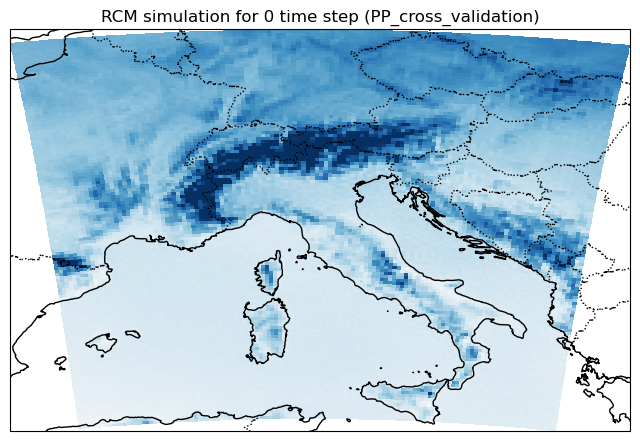

In [39]:
time_idx = 0

plot_data_map(data=y_eval_pred.isel(time=0), var_name=var_target, domain=domain,
              vmin=270, vmax=305,
              fig_title=f'RCM simulation for {time_idx} time step ({evaluation_experiment})',
              figsize=(8,8), cmap='RdBu_r')

**References**

[1] Baño-Medina, J., Manzanas, R., Cimadevilla, E., Fernández, J., González-Abad, J., Cofiño, A. S., & Gutiérrez, J. M. (2022). **Downscaling multi-model climate projection ensembles with deep learning (DeepESD): contribution to CORDEX EUR-44**. Geoscientific Model Development Discussions, 2022, 1-14.

[2] Baño-Medina, J., Iturbide, M., Fernández, J., & Gutiérrez, J. M. (2024). **Transferability and explainability of deep learning emulators for regional climate model projections: Perspectives for future applications**. Artificial Intelligence for the Earth Systems, 3(4), e230099.

[3] González-Abad, J., & Gutiérrez, J. M. (2025). **Are Deep Learning Methods Suitable for Downscaling Global Climate Projections? An Intercomparison for Temperature and Precipitation over Spain**. Artificial Intelligence for the Earth Systems, 4(4), 240121.